
https://medium.com/fintechexplained/ever-wondered-why-normal-distribution-is-so-important-110a482abee3

In [88]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats 


In [116]:
import numpy as np
import scipy
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats 


# emb_name = 'control_meditation_hypnose' #or 'run-1_run-2_run-3' (for block comparison)
emb_name = 'hypnose'

emb_path = '/home/romy.beaute/projects/hypnomed/data/emb_matrices/group_{}_embedding.mat'.format(emb_name)


emb = scipy.io.loadmat(emb_path)

#------------------------ informations embedding ------------------------
print(emb.keys())
print('States : ',emb['states'])
print('n={} subjects'.format(len(emb['subs'])))
print('Emb shape : ',emb['emb'].shape)
sublist = emb['subs'].tolist()
#------------------------------------------------------------------------ 

embs = emb['emb'][:,:,0] #keep only first PG
print(embs.shape)

dict_keys(['__header__', '__version__', '__globals__', 'emb', 'subs', 'states'])
States :  ['hypnose']
n=40 subjects
Emb shape :  (39, 18715, 5)
(39, 18715)


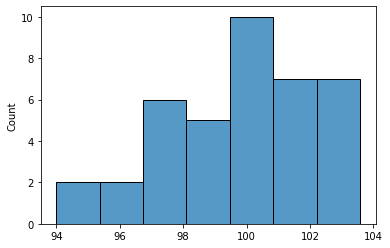

In [117]:
mu = 100 #centered around 100
sigma = 2.5 #std
n_samples = embs.shape[0] 
array = np.random.normal(mu, sigma, n_samples) #generate n=n_samples from normal distribution

sns.histplot(array)
plt.show()

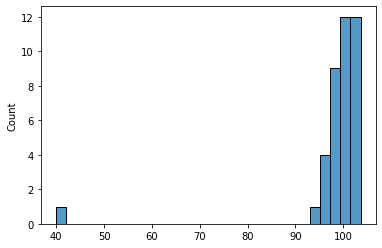

In [118]:
array[14] = 40 #simulate outlier (corresp subject 15)
sns.histplot(array)
plt.show()

(39,)


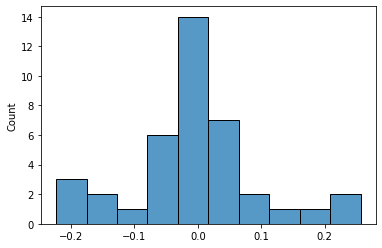

In [119]:
emb_mean = np.mean(embs,axis=1) #mean PG for each subject
print(emb_mean.shape)
df = pd.DataFrame(emb_mean, columns=["PG_mean"]) 

sns.histplot(emb_mean)
plt.show()

Z-score is used to convert the data into another dataset with mean = 0.

$$ Z = \frac{x_i - \bar{X}}{s}$$

In [120]:
#Calculating The Z-Scores (for each column)

for col in df.columns:
    col_zscore = col + "_zscore" #create z_score col for each var (we have only one here)
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
df.head()


,PG_mean,PG_mean_zscore
0,0.000691,0.044278
1,-0.042383,-0.379085
2,-0.001251,0.025193
3,-0.000580,0.031783
4,0.067066,0.696656


- Z-Score is essentially how many standard deviations away is my actual value from the mean value
- Can define the threshold value for the z score to classify a point as an outlier or not in the current scheme of things

In [121]:
thres = 2
df["outlier"] = (abs(df["PG_mean_zscore"])>thres).astype(int) #define new outlier col

print(df.outlier.value_counts()) #show number of outliers == 0 and outliers == 1

print("number of outliers = " + str(df.outlier.value_counts()[1]))

df.loc[df.outlier==1]

0    35
1     4
Name: outlier, dtype: int64
number of outliers = 4


,PG_mean,PG_mean_zscore,outlier
9,-0.223435,-2.158587,1
15,0.256781,2.561304,1
27,0.202067,2.023537,1
29,0.252006,2.514376,1


In [122]:
def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.2, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.histplot(df[col], kde=False, bins = 50,color="r")
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step)
    plt.show()

In [123]:
def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = df["PG_mean_zscore"]
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile_threshold)

/home/romy.beaute/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


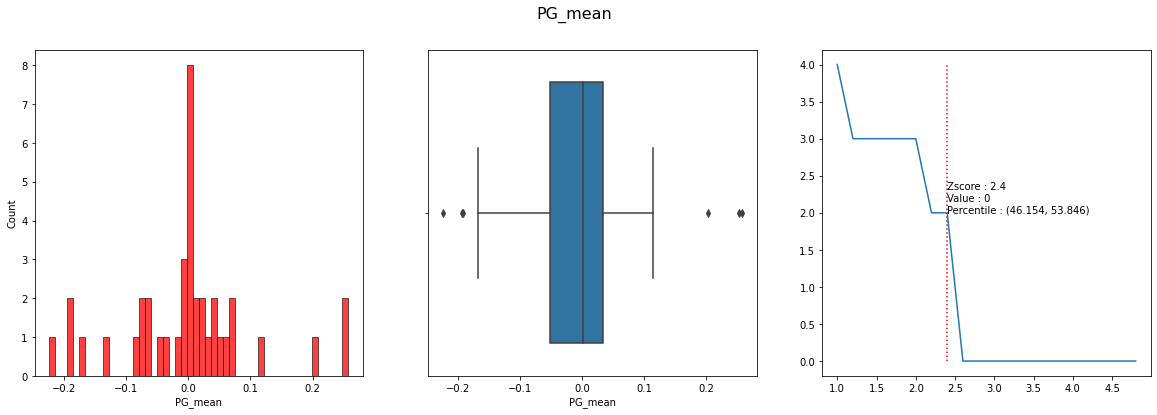

In [124]:
outlier_inspect(df,"PG_mean")

Zscore gives us the optimized threshold value

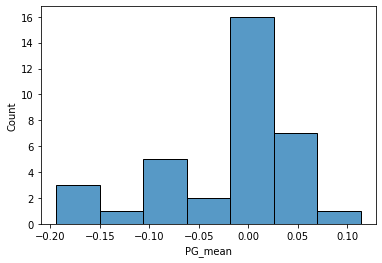

In [125]:
df=df.loc[df.outlier == 0] #supress the outlier(s)
sns.histplot(df["PG_mean"])
plt.show()